<a href="https://colab.research.google.com/github/wlg1/analogous_neuron_circuit_expms/blob/main/MNIST_actvs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/mishra1993/pytorch-multi-layer-perceptron-mnist/notebook

https://www.kaggle.com/code/pinocookie/pytorch-simple-mlp

In [1]:
%%capture
import torch
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

## Dataset

In [2]:
%%capture
!git clone https://github.com/wlg1/analogous_neuron_circuit_expms.git

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/analogous_neuron_circuit_expms/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download digit-recognizer/data
! unzip data.zip

In [3]:
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [4]:
class TrainMNIST(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, we use ToTensor(), so we define the numpy array like (H, W, C)
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        label = self.data.iloc[index, 0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
        
class TestMNIST(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, we use ToTensor(), so we define the numpy array like (H, W, C)
        image = self.data.iloc[index, 0:].values.astype(np.uint8).reshape((28, 28, 1))
    
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image

In [5]:
train_data = TrainMNIST('/content/sample_data/mnist_train_small.csv', transform=transforms.ToTensor())
test_data = TestMNIST('/content/sample_data/mnist_test.csv', transform=transforms.ToTensor())

In [6]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
#transform = transforms.ToTensor()

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers,)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

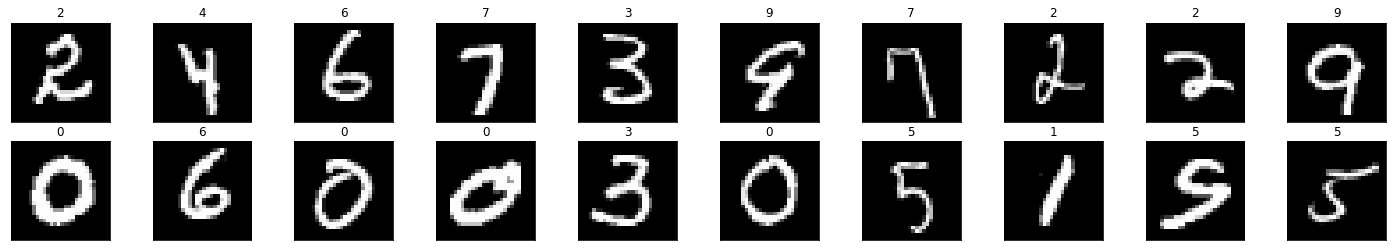

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

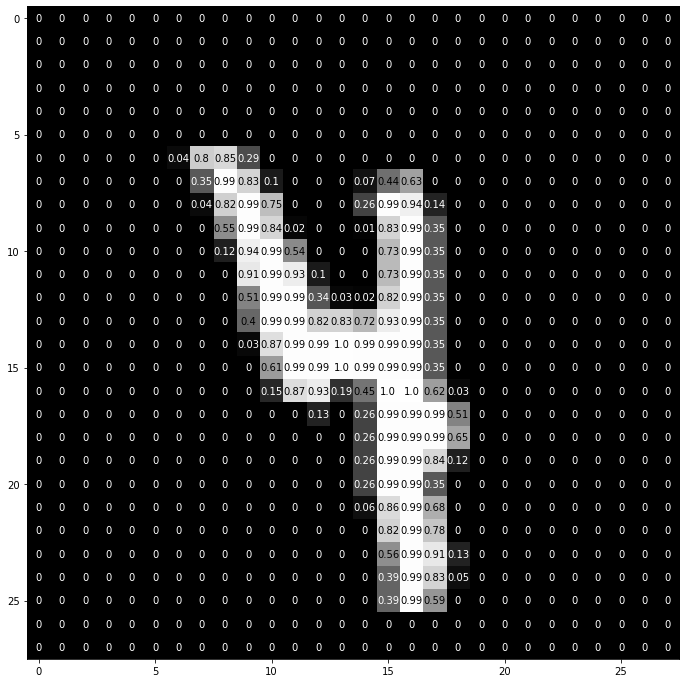

In [8]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(28 * 28, hidden_1) # linear layer (784 -> hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28) # flatten image input
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# class Feedforward(torch.nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(Feedforward, self).__init__()
#         self.input_size = input_size
#         self.hidden_size  = hidden_size
#         self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
#         self.relu = torch.nn.ReLU()
#         self.fc2 = torch.nn.Linear(self.hidden_size, 1)
#         self.sigmoid = torch.nn.Sigmoid()
#     def forward(self, x):
#         hidden = self.fc1(x)
#         relu = self.relu(hidden)
#         output = self.fc2(relu)
#         output = self.sigmoid(output)
#         return output

In [ ]:
# model = Feedforward(2, 2)
# criterion = torch.nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [20]:
# get previous last layer name
named_layers = dict(model.named_modules())
layers = list(named_layers.keys())

# '' is first layer, the input, so disregard it
layers = [x for x in layers if x != '']  

In [ ]:
layers

['fc1', 'fc2', 'fc3', 'dropout']

In [11]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

In [12]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{}".format(str(preds[idx].item())))

ValueError: ignored

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, 
    num_workers=num_workers)
def predict(model, dataloader):
    prediction_list = []
    for i, batch in enumerate(dataloader):
        outputs = model(batch)
        _, predicted = torch.max(outputs.data, 1) 
        prediction_list.append(predicted.cpu())
    return prediction_list
predictions = predict(model,test_loader)
predictions = np.array(predictions)
test_data = pd.read_csv("../input/test.csv")


submission = pd.DataFrame(data={
    "ImageId": test_data.index + 1,
    "Label": predictions
})
submission.to_csv("submission.csv", index=None)
submission.head(n=12).T



---
# Get Activations


In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
images.shape

torch.Size([20, 1, 28, 28])

In [ ]:
out = model(images)
out.shape

torch.Size([20, 10])

In [ ]:
# prep images for display
# https://stackoverflow.com/questions/62490720/valueerror-type-must-be-a-sub-type-of-ndarray-type
# images = images.numpy()

In [ ]:
def get_activations(input, layer_name):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    for name_to_check, layer in model.named_modules():
        if name_to_check == layer_name:
            break
    layer.register_forward_hook(get_activation(layer_name))
    
    output = model(input)

    return activation.copy()  #else will return the same actvs of model

In [ ]:
activation_nameVal = {}
for layer_name in layers:
    activation_nameVal[layer_name] = get_activations(images, layer_name)[layer_name]

In [ ]:
activation_nameVal['fc1'].shape

torch.Size([20, 512])

The first 2 train images are 7, and 3rd is 0. Compare similarities and diffs for all layers

Attempt 1: Brute force sum

In [ ]:
for layer_name in layers:
    pair_combo_list = [(0, 1), (0, 2), (1, 2)]
    for pc in pair_combo_list:
        diffs = sum(activation_nameVal[layer_name][pc[0]] - activation_nameVal[layer_name][pc[1]])
        print(layer_name, pc, diffs)

fc1 (0, 1) tensor(-40.8472)
fc1 (0, 2) tensor(-30.6577)
fc1 (1, 2) tensor(10.1894)
fc2 (0, 1) tensor(12.9846)
fc2 (0, 2) tensor(39.5077)
fc2 (1, 2) tensor(26.5231)
fc3 (0, 1) tensor(0.5368)
fc3 (0, 2) tensor(0.7160)
fc3 (1, 2) tensor(0.1792)
dropout (0, 1) tensor(31.8740)
dropout (0, 2) tensor(61.2275)
dropout (1, 2) tensor(29.3535)


We expect that (0,1), both sevens, should have something differing it from (0,2) and (1,2), which is sevens to 0. But there doesn't seem to be.

Rather than aggregate sums, try knockout of each indiv neuron, or combos of indiv neuron, and see how that changes output prob.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, 
    num_workers=num_workers)

In [ ]:
train_loader

In [ ]:
outputs = model(images)
_, predicted = torch.max(outputs.data, 1) 

In [ ]:
predicted

tensor([6, 1, 8, 5, 6, 2, 7, 0, 5, 0, 5, 7, 9, 4, 2, 5, 3, 7, 2, 6])

In [ ]:
labels

tensor([6, 1, 8, 5, 6, 2, 7, 0, 5, 0, 5, 7, 9, 4, 2, 5, 3, 7, 2, 6])

No wonder why it wasn't having good activations; each time you do iter(dataset), you get different images. So it wasn't a 7 vs 7 vs 0 you were comparing.

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)

outputs = model(images)
_, predicted = torch.max(outputs.data, 1) 
predicted

tensor([2, 8, 6, 7, 8, 0, 6, 7, 9, 8, 5, 7, 1, 3, 4, 4, 0, 7, 7, 7])

In [ ]:
labels

tensor([2, 8, 6, 7, 8, 0, 6, 7, 9, 8, 5, 7, 1, 3, 4, 4, 0, 7, 7, 7])

In [ ]:
from itertools import chain, combinations
def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1)))

stuff = [1, 2, 3]
output_list = [subset for subset in all_subsets(stuff) if len(subset) == 2]
output_list

[(1, 2), (1, 3), (2, 3)]

In [ ]:
for layer_name in layers:
    input_inds = [-1, -2, -3, -4]
    pair_combo_list = [subset for subset in all_subsets(input_inds) if len(subset) == 2]
    for pc in pair_combo_list:
        diffs = sum(activation_nameVal[layer_name][pc[0]] - activation_nameVal[layer_name][pc[1]])
        print(layer_name, pc, diffs)

fc1 (-1, -2) tensor(-14.6102)
fc1 (-1, -3) tensor(-23.6727)
fc1 (-1, -4) tensor(-40.8599)
fc1 (-2, -3) tensor(-9.0625)
fc1 (-2, -4) tensor(-26.2498)
fc1 (-3, -4) tensor(-17.1873)
fc2 (-1, -2) tensor(-19.4811)
fc2 (-1, -3) tensor(-6.2456)
fc2 (-1, -4) tensor(-73.2264)
fc2 (-2, -3) tensor(13.2354)
fc2 (-2, -4) tensor(-53.7454)
fc2 (-3, -4) tensor(-66.9808)
fc3 (-1, -2) tensor(0.5870)
fc3 (-1, -3) tensor(1.2141)
fc3 (-1, -4) tensor(0.4785)
fc3 (-2, -3) tensor(0.6271)
fc3 (-2, -4) tensor(-0.1085)
fc3 (-3, -4) tensor(-0.7356)
dropout (-1, -2) tensor(-37.0762)
dropout (-1, -3) tensor(-17.4124)
dropout (-1, -4) tensor(-80.3028)
dropout (-2, -3) tensor(19.6637)
dropout (-2, -4) tensor(-43.2266)
dropout (-3, -4) tensor(-62.8903)


Group all those with -4 together vs those w/o -4. Is there a pattern that distinguishes these two groups? Is it dependent by layer?

You can try an even smaller model that uses less neurons and only compares 0 vs 8. Or 1 vs 7.

"Edge detectors"

Also, instead of using data loader to get random batches, save a batch so it's not random. or use seed.

In [14]:
len(train_data)

19999

In [ ]:
len(train_idx)

16000

In [ ]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
train_data[0][1]

5

In [ ]:
train_data[1][1]

7

In [15]:
inds_0 = []
for id in range(len(train_data)):
    if train_data[id][1] == 0:
        inds_0.append(id)

In [16]:
len(inds_0)

1962

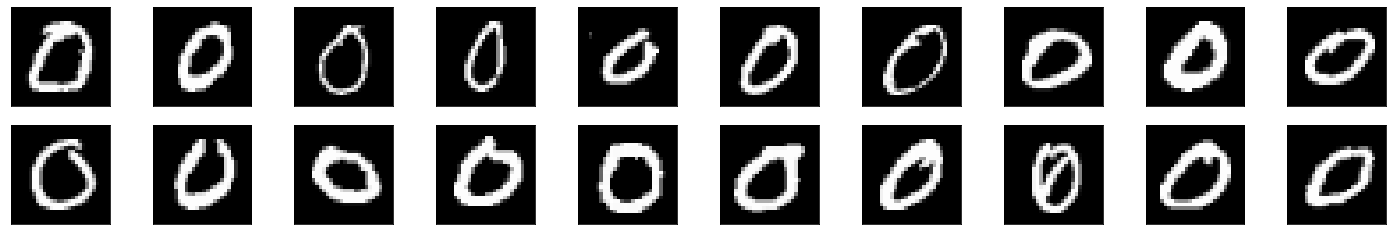

In [17]:
fig = plt.figure(figsize=(25, 4))
for num, idx in enumerate(inds_0[0:20]):
    ax = fig.add_subplot(2, 20/2, num+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(train_data[idx][0]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    # ax.set_title(str(labels[idx].item()))

# Modify weights



In [48]:
inds_0[0]

5

In [49]:
train_data.__getitem__(5)[1]

0

In [ ]:
train_data.__getitem__(5)[0]

In [50]:
out = model(train_data.__getitem__(5)[0])

In [52]:
out

tensor([[15.6173, -8.2198,  6.6368, -0.1823, -9.3209,  0.7847, -0.4946,  0.0670,
         -6.0369, -1.2912]], grad_fn=<AddmmBackward0>)

In [ ]:
for ly in model.named_modules():
    if ly[0] != '' and ly[0] != 'dropout':
        print(ly[1].weight.data)

In [36]:
layers = ['fc1', 'fc2', 'fc3']
for ly in model.named_modules():
    if ly[0] == 'fc1':
        print(ly[1].weight.data.shape)

torch.Size([512, 512])


Neurons are rows in weights (for go into neuron) and cols in next layer weight matrix (for go out of neuron). To knockout a neuron, set all weights in the incoming weight matrix to 0, and also to outgoing weight matrix.

Before modifying neurons, let's modify a single weight.

In [83]:
model_copy = copy.deepcopy(model)

In [84]:
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data

Set entire first row to 0. Every single pixel (out of 784) that goes into first neuron (out of 512) is 'blocked'. Thus the outcoming activations will also be blocked if bias is set to 0.

In [85]:
layer_0_to_1_weights[0] = 0

In [86]:
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        print(layer_0_to_1_weights)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0049,  0.0246,  0.0163,  ..., -0.0185, -0.0082,  0.0146],
        [-0.0130, -0.0197,  0.0202,  ..., -0.0347,  0.0135, -0.0022],
        ...,
        [-0.0291,  0.0301,  0.0201,  ..., -0.0129,  0.0162,  0.0297],
        [-0.0276, -0.0149, -0.0290,  ...,  0.0331,  0.0246, -0.0305],
        [-0.0231, -0.0138,  0.0048,  ...,  0.0214, -0.0013,  0.0294]])


In [87]:
out = model_copy(train_data.__getitem__(5)[0])
out

tensor([[15.4554, -7.5636,  5.6183,  1.0914, -9.2264,  0.3566, -1.5256,  0.6211,
         -6.5946, -0.4437]], grad_fn=<AddmmBackward0>)

ISSUE: Dropout is random, so get diff output values each run

In [90]:
torch.argmax(out).item()

0

In [91]:
for weight in range(512):
    model_copy = copy.deepcopy(model)
    for ly in model_copy.named_modules():
        if ly[0] == 'fc1':
            layer_0_to_1_weights = ly[1].weight.data
            break
    layer_0_to_1_weights[weight] = 0
    out = model_copy(train_data.__getitem__(5)[0])
    if torch.argmax(out).item() != 0:
        print(weight, torch.argmax(out).item())

In [92]:
model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
layer_0_to_1_weights[layer_0_to_1_weights !=0] = 0
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        print(layer_0_to_1_weights)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [93]:
out = model_copy(train_data.__getitem__(5)[0])
out

tensor([[-0.4796,  0.2182, -0.3352, -0.9927,  0.5191,  1.8772,  0.0308,  0.3985,
         -1.1687, -0.1355]], grad_fn=<AddmmBackward0>)

In [95]:
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

5


Changing a single neuron row still allows it to recognize 0. Destroying the 1st layer obviously makes it fail; that's an extreme case.

So for mid-cases, let's destroy combos of neurons. Maybe binary search? Dynamic programming?

In [97]:
weights_to_destroy = list(range(256))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

In [98]:
out

tensor([[ 7.3655e+00, -4.4257e+00,  2.4717e+00,  1.3028e+00, -6.4183e+00,
          2.0776e+00, -9.2014e-01,  3.2406e-03, -2.5161e+00, -2.2169e-01]],
       grad_fn=<AddmmBackward0>)

In [99]:
weights_to_destroy = list(range(400))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

In [100]:
out

tensor([[ 3.3306, -1.7898,  1.1541,  0.2265, -2.8633,  2.9666,  0.4339, -1.1646,
         -1.4329, -1.0655]], grad_fn=<AddmmBackward0>)

In [101]:
weights_to_destroy = list(range(500))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

5


So even at 400 first layer neurons gone, it can still recognize 0 (though its performance overall may be bad). But at 500, it fails. So try binary searching. Note more combos where it fails (non-consecutive neurons in matrix) may exist.

In [102]:
weights_to_destroy = list(range(450))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

5


In [103]:
weights_to_destroy = list(range(425))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

7


In [104]:
weights_to_destroy = list(range(412))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

In [105]:
weights_to_destroy = list(range(418))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

In [106]:
weights_to_destroy = list(range(421))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

In [107]:
weights_to_destroy = list(range(423))

model_copy = copy.deepcopy(model)
for ly in model_copy.named_modules():
    if ly[0] == 'fc1':
        layer_0_to_1_weights = ly[1].weight.data
        break
for weight in weights_to_destroy:
    layer_0_to_1_weights[weight] = 0
out = model_copy(train_data.__getitem__(5)[0])
if torch.argmax(out).item() != 0:
    print(torch.argmax(out).item())

5


In [108]:
out

tensor([[ 2.5940, -0.7208,  1.0590, -0.5884, -1.6612,  3.1647, -0.0438,  1.0911,
         -3.3205, -1.8568]], grad_fn=<AddmmBackward0>)

Plot how the prob changes over time as more weights destroyed.

## Modify weights for multiple input images

For each image, destroy 1st layer weights, cutting it in half until class is 'restored' back to 0. Save the image index and this 'number of neurons' metric.

In [ ]:
# binary search (impelment later)
# https://www.geeksforgeeks.org/python-program-for-binary-search/

image_neuron_list = []
for img_ind in ind_0:
    num_w = 512
    while True:
        weights_to_destroy = list(range(num_w))

        model_copy = copy.deepcopy(model)
        for ly in model_copy.named_modules():
            if ly[0] == 'fc1':
                layer_0_to_1_weights = ly[1].weight.data
                break
        for weight in weights_to_destroy:
            layer_0_to_1_weights[weight] = 0
        out = model_copy(train_data.__getitem__(5)[0])
        '''if new midpt reaches corr label, go right. else, go left. b/c answer val midpt will always be bigger, so this is an 
        'easier' version of binary search. end when new bigger value is also 'correct label' '''
        ''' 512 wrong -> 256 right -> 400 right -> 450 right -> 475 wrong -> 460; end b/c 475-460 is 'within threshold' '''
        ''' 512 wrong -> 256 right -> 400 wrong -> 300 .... '''

        '''based on examples, go right if 'corr label', go left if 'wrong label'. left is between closest val that gets corr label
        and right is b/w curr val and closest val that gets wrong label'''

        # if torch.argmax(out).item() == 0:
        #     image_neuron_list.append(img_ind, num_w)
        #     break
        # else:
        #     num_w

Actually b/c output val is close to 512, it's prob faster to just increment down by 1.

In [120]:
# just output at first val that's correct by going down 1 increment

import pdb

image_neuron_list = []
neuron_list = []
for img_ind in inds_0:
    num_w = 512
    while True:
        weights_to_destroy = list(range(num_w))

        model_copy = copy.deepcopy(model)
        for ly in model_copy.named_modules():
            if ly[0] == 'fc1':
                layer_0_to_1_weights = ly[1].weight.data
                break
        for weight in weights_to_destroy:
            layer_0_to_1_weights[weight] = 0
        out = model_copy(train_data.__getitem__(img_ind)[0])
        if torch.argmax(out).item() == 0:
            image_neuron_list.append((img_ind, num_w))
            neuron_list.append(num_w)
            break
        else:
            num_w -= 1

KeyboardInterrupt: ignored

In [122]:
len(image_neuron_list)

364

(array([  2.,   3.,   3.,  13.,  13.,  35.,  61., 145.,  63.,  26.]),
 array([329. , 342.8, 356.6, 370.4, 384.2, 398. , 411.8, 425.6, 439.4,
        453.2, 467. ]),
 <a list of 10 Patch objects>)

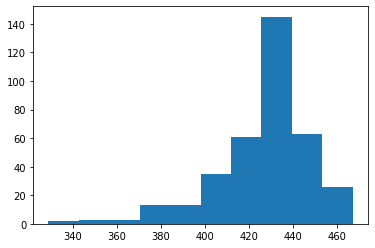

In [123]:
plt.hist(neuron_list, 10)

# Actv Max

https://github.com/christianversloot/machine-learning-articles/blob/main/visualizing-keras-model-inputs-with-activation-maximization.md

https://punndeeplearningblog.com/tutorial/visualizing-deep-learning/

# Compare slight mods

---
Now slightly modify the input and see what happens to each layer!

Try different modification levels


In [ ]:
input_2 = x_train[0] + torch.tensor([0.1,0])
input_2

tensor([ 0.6815, -8.9559])

In [ ]:
for layer_name in layers:
    print(get_activations(input_2, layer_name))

{'fc1': tensor([7.9596, 8.3923])}
{'relu': tensor([7.9596, 8.3923])}
{'fc2': tensor([3.2521])}
{'sigmoid': tensor([0.9627])}




---



In [ ]:
input_3 = x_train[0] + torch.tensor([1,0])
for layer_name in layers:
    print(get_activations(input_3, layer_name))

{'fc1': tensor([8.1595, 8.5033])}
{'relu': tensor([8.1595, 8.5033])}
{'fc2': tensor([3.0181])}
{'sigmoid': tensor([0.9534])}


In [ ]:
model.fc1.weight.data

tensor([[ 0.2221, -0.5793],
        [ 0.1234, -1.1833]])

In [ ]:
torch.matmul(model.fc1.weight.data, input_2 ) + model.fc1.bias

tensor([7.9596, 8.3923], grad_fn=<AddBackward0>)

Find a local motif. This is a local circuit?

## Compare mods as interpolate from 1 number to another

Eg) Transform input 0 to 8